<a href="https://colab.research.google.com/github/ansonkwokth/TableTennisPrediction/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import copy
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [92]:
month = 2

df_hist = pd.read_excel('/content/TableTennisResult.xlsx')

# df_hist = df_hist[df_hist.Date.dt.month == month]

In [93]:
winrate_dt = {}
uncert_dt = {}
total_wins = 0
total_games = 0

winrate_P_dt = {}
uncert_P_dt = {}
P_th = 0.6
total_wins_P = 0
total_games_P = 0

for d in df_hist.Date.unique():
    if pd.isnull(d): continue
    df_hist_i = df_hist[df_hist.Date == d]
    n_game = len(df_hist_i)
    n_win = len(df_hist_i[df_hist_i.Win==1])
    p = (n_win / n_game)
    uncert_i = (p*(1-p)/len(df_hist_i))**0.5
    winrate_dt[d] = p
    uncert_dt[d] = uncert_i

    total_wins += n_win
    total_games += n_game

    df_hist_P_i = df_hist_i[df_hist_i.Prob >= P_th]
    n_game_P = len(df_hist_P_i)
    n_win_P = len(df_hist_P_i[df_hist_P_i.Win==1])
    p_P = (n_win_P / n_game_P)
    uncert_P_i = (p_P*(1-p_P)/len(df_hist_P_i))**0.5
    winrate_P_dt[d] = p_P
    uncert_P_dt[d] = uncert_P_i

    total_wins_P += n_win_P
    total_games_P += n_game_P

avg_winrate = total_wins / total_games
avg_winrate_P = total_wins_P / total_games_P
print(f"Average winrate: {avg_winrate:.4f}")
print(f"Average winrate: {avg_winrate_P:.4f}")

Average winrate: 0.7338
Average winrate: 0.7672


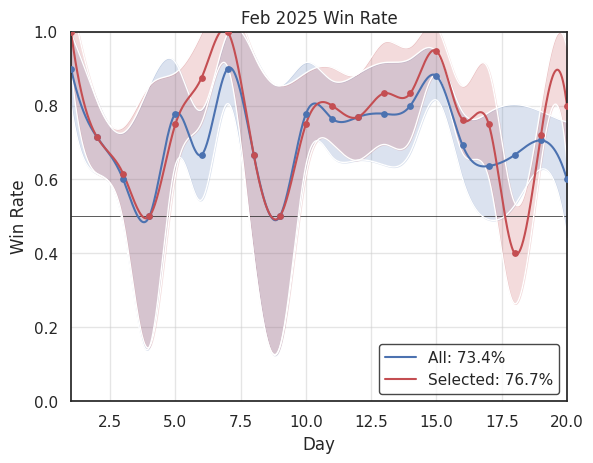

In [94]:
dates = winrate_dt.keys()
p = np.array(list(winrate_dt.values()))
p_P = np.array(list(winrate_P_dt.values()))
uncert = np.array(list(uncert_dt.values()))
uncert_P = np.array(list(uncert_P_dt.values()))

def smooth_p_uncert(p, uncer):
    cubic_interpolation_model = interp1d(np.arange(len(p))+1, p, kind = "cubic")
    X_p=np.linspace(1, len(p), 1000)
    Y_p=cubic_interpolation_model(X_p)

    cubic_interpolation_model = interp1d(np.arange(len(p))+1, uncert, kind = "cubic")
    Y_uncert=cubic_interpolation_model(X_p)
    return X_p, Y_p, Y_uncert

X_p, Y_p, Y_uncert = smooth_p_uncert(p, uncert)
X_p_P, Y_p_P, Y_uncert_P = smooth_p_uncert(p_P, uncert_P)

plt.axhline(0.5, color='k', lw=0.5)

# plt.plot(X_p, Y_p + Y_uncert, color='k', lw=1)
# plt.plot(X_p, Y_p - Y_uncert, color='k', lw=1)
plt.fill_between(X_p,
                 Y_p + Y_uncert,
                 Y_p - Y_uncert,
                 color='b', alpha=0.2)
plt.fill_between(X_p_P,
                 Y_p_P + Y_uncert_P,
                 Y_p_P - Y_uncert_P,
                 color='r', alpha=0.2)
plt.plot(X_p_P, Y_p_P + Y_uncert_P, color='white', lw=1)
plt.plot(X_p_P, Y_p_P - Y_uncert_P, color='white', lw=1)
plt.plot(X_p, Y_p + Y_uncert, color='white', lw=1)
plt.plot(X_p, Y_p - Y_uncert, color='white', lw=1)

plt.plot(X_p, Y_p, color='b', label=f'All: {avg_winrate*100:.1f}%')
plt.plot(X_p_P, Y_p_P, color='r', label=f'Selected: {avg_winrate_P*100:.1f}%')
plt.scatter(np.arange(len(winrate_dt))+1, p, color='b', s=15, zorder=999)
plt.scatter(np.arange(len(winrate_dt))+1, p_P, color='r', s=15, zorder=999)

plt.ylim(0, 1)
plt.xlabel("Day")
plt.ylabel("Win Rate")

plt.margins(x=0)
plt.grid(True, linestyle='-', alpha=0.5)

legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')

plt.title("Feb 2025 Win Rate");

In [95]:
ret_dt = {}

for d in df_hist.Date.unique():
    if pd.isnull(d): continue
    df_hist_i = df_hist[df_hist.Date == d]

    cost = len(df_hist_i)
    gain = df_hist_i[df_hist_i.Win==1]['WinnerOdd'].sum()
    ret_dt[d] = (gain - cost)






In [96]:
ret_par_dt = {}
n_par = 3

for d in df_hist.Date.unique():
    if pd.isnull(d): continue
    df_hist_i = df_hist[df_hist.Date == d]

    # df_hist_psort_i = df_hist_i
    # df_hist_psort_i = df_hist_i.sort_values("Prob")
    df_hist_psort_i = df_hist_i.sort_values("Prob", ascending=False)
    # df_hist_psort_i = df_hist_i[df_hist_i.Prob > P_th].sort_values("Prob", ascending=False)

    ii = 0
    odd_par = 1
    win_par = 1.0
    cost_par = 0
    gain_par = 0
    for idx, row in df_hist_psort_i.iterrows():
        ii += 1
        odd_par *= row['WinnerOdd']
        win_par *= row.Win
        if ii == n_par:
            cost_par += 1
            gain_par += win_par * odd_par
            ii = 0
            odd_par = 1
            win_par = 1.0
    if ii != 0:
        cost_par += 1
        gain_par += win_par * odd_par

    ret_par_dt[d] = gain_par - cost_par






In [97]:
ret_EV_dt = {}

for d in df_hist.Date.unique():
    if pd.isnull(d): continue
    df_hist_i = df_hist[df_hist.Date == d]

    df_hist_i['WinnerEV'] = df_hist_i['WinnerOdd'] * df_hist_i['Prob']
    df_hist_i['LoserEV'] = df_hist_i['LoserOdd'] * (1 - df_hist_i['Prob'])

    df_winnerbuy_i = df_hist_i[df_hist_i.WinnerEV > 1]
    df_loserbuy_i = df_hist_i[df_hist_i.LoserEV > 1]

    df_winnerbuy_win_i = df_winnerbuy_i[df_winnerbuy_i.Win==1]
    df_loserbuy_win_i = df_loserbuy_i[df_loserbuy_i.Win==0]

    gain1 = 0 if len(df_winnerbuy_win_i) == 0 else df_winnerbuy_win_i.WinnerOdd.sum()
    gain2 = 0 if len(df_loserbuy_win_i) == 0 else df_loserbuy_win_i.LoserOdd.sum()
    gain = gain1 + gain2
    cost = len(df_winnerbuy_i) + len(df_loserbuy_i)
    ret_EV_dt[d] = (gain - cost)




In [102]:
ret_bk_dt = {}

for d in df_hist.Date.unique():
    if pd.isnull(d): continue
    df_hist_i = df_hist[df_hist.Date == d]
    df_hist_i['Bookie'] = df_hist_i['WinnerOdd'] < df_hist_i['LoserOdd']

    cost = len(df_hist_i)
    gain1 = df_hist_i[(df_hist_i['Bookie'] == df_hist_i['Win']) & (df_hist_i['Bookie'] == True)]['WinnerOdd']
    gain2 = df_hist_i[(df_hist_i['Bookie'] == df_hist_i['Win']) & (df_hist_i['Bookie'] == False)]['LoserOdd']
    gain = gain1.sum() + gain2.sum()

    ret_bk_dt[d] = (gain - cost)





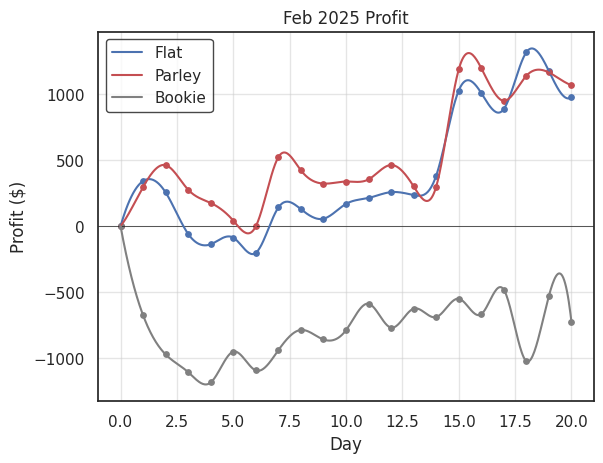

In [103]:

cost = 100

def smoothing(ret_dt):
    x = np.arange(len(ret_dt) + 1)
    y = np.append([0], np.cumsum(list(ret_dt.values())))
    cubic_interpolation_model = interp1d(x, y, kind = "cubic")

    # Plotting the Graph
    X_=np.linspace(x.min(), x.max(), 500)
    Y_=cubic_interpolation_model(X_)
    return X_, Y_


X_, Y_ = smoothing(ret_dt)
X_par_, Y_par_ = smoothing(ret_par_dt)
X_EV_, Y_EV_ = smoothing(ret_EV_dt)
X_bk_, Y_bk_ = smoothing(ret_bk_dt)

plt.axhline(0.5, color='k', lw=0.5)
plt.plot(X_, Y_*cost, color='b', label="Flat")
plt.scatter(range(len(ret_dt.keys())+1), np.cumsum([0]+list(ret_dt.values()))*cost, s=15, color='b')
plt.plot(X_par_, Y_par_*cost, color='r', label="Parley")
plt.scatter(range(len(ret_par_dt.keys())+1), np.cumsum([0]+list(ret_par_dt.values()))*cost, s=15, color='r')
plt.plot(X_bk_, Y_bk_*cost, color='grey', label="Bookie")
plt.scatter(range(len(ret_bk_dt.keys())+1), np.cumsum([0]+list(ret_bk_dt.values()))*cost, s=15, color='grey')
# plt.plot(X_EV_, Y_EV_*cost, color='k', label="+EV")
# plt.scatter(range(len(ret_EV_dt.keys())+1), np.cumsum([0]+list(ret_EV_dt.values()))*cost, s=15, color='k')
plt.xlabel("Day")
plt.ylabel(f"Profit ($)")
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5)

legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')

plt.title("Feb 2025 Profit");

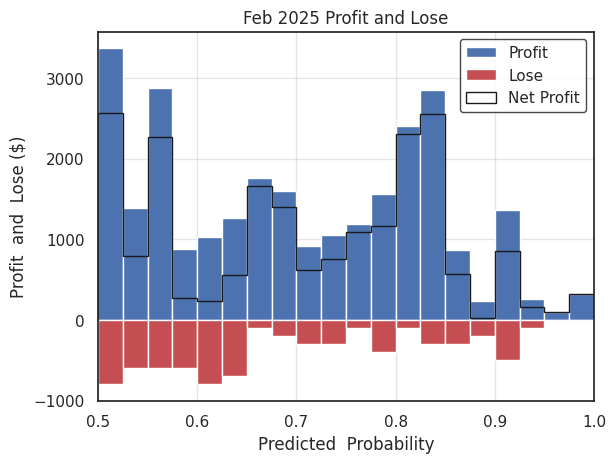

In [104]:
df_hist['PnL'] = df_hist['WinnerOdd'].copy()
df_hist.loc[df_hist.Win==1, "PnL"] = df_hist[df_hist.Win==1]['WinnerOdd']
df_hist.loc[df_hist.Win==0, "PnL"] = -1

win_odd = df_hist[df_hist.Win == 1]['WinnerOdd']
lose_odd = df_hist[df_hist.Win == 0]['WinnerOdd']
all_odd = df_hist['PnL']
win_prob = df_hist[df_hist.Win == 1]['Prob']
lose_prob = df_hist[df_hist.Win == 0]['Prob']
all_prob = df_hist['Prob']

range_ = [0.5, 1]
bins_=20
plt.hist(win_prob, weights=win_odd*cost, range=range_, bins=bins_, label='Profit', color='b');
plt.hist(lose_prob, weights=[-cost]*len(lose_odd), range=range_, bins=bins_, label='Lose', color='r');
plt.hist(all_prob, weights=all_odd*cost, range=range_, bins=bins_, color='k', histtype='step', label='Net Profit');
plt.grid()
plt.margins(x=0)

plt.xlabel("Predicted  Probability")
plt.ylabel(f"Profit  and  Lose ($)")
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5)

legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')

plt.title("Feb 2025 Profit and Lose");